In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import basic_functions as bf
import itertools
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from functools import partial

import warnings
warnings.filterwarnings("ignore") 

In [2]:
path = '../namesbystate/'
state = 'merged'
full_path = path+state+'.csv'
data_set = pd.read_csv(full_path)

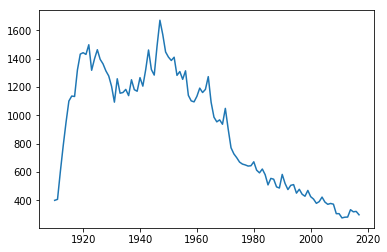

In [13]:
data=bf.get_year("AL","John")
dataM=data[data["Gender"]=="M"]
plt.plot(dataM["Year"],dataM["Occurence"])

# Sélection du modèle

In [4]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries["Occurence"].rolling(15).mean()
    rolstd =timeseries["Occurence"].rolling(15).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries["Year"],timeseries["Occurence"], color='blue',label='Original')
    mean = plt.plot(timeseries["Year"],rolmean, color='red', label='Rolling Mean')
    std = plt.plot(timeseries["Year"],rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries["Occurence"], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    return dfoutput


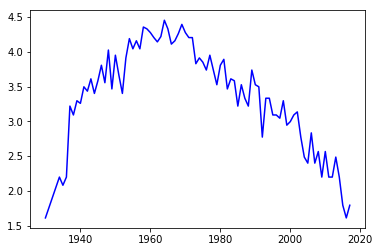

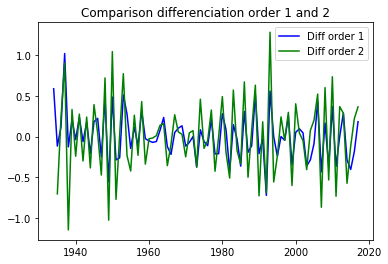

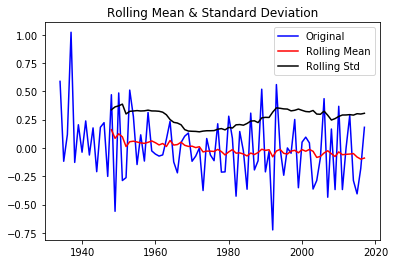

Results of Dickey-Fuller Test:
Test Statistic                -5.731079e+00
p-value                        6.598116e-07
#Lags Used                     2.000000e+00
Number of Observations Used    8.100000e+01
Critical Value (1%)           -3.513790e+00
Critical Value (5%)           -2.897943e+00
Critical Value (10%)          -2.586191e+00
dtype: float64


In [5]:
transformation="log"
_pow = np.power
if transformation=="log":
    trans_func = np.log
    trans_inv = np.exp
elif transformation=="sqrt":
    trans_func = np.sqrt
    trans_inv = lambda x : _pow(x, 2)
elif transformation=="curt": #cube root
    trans_func = lambda x : _pow(x, 1/3)
    trans_inv = lambda x : _pow(x, 3)

ts_log = trans_func(dataM["Occurence"]) #np.log(dataM["Occurence"])

#Method 1 of removing trend, not good
#moving_avg = ts_log.rolling(15).mean()
#plt.plot(dataM["Year"],ts_log,label="ts_log")
#plt.plot(dataM["Year"],moving_avg, color='red',label="moving_avg")

#plt.title('Rolling Mean of ts_log')
#plt.legend(loc='best')
#plt.show()

#ts_log_moving_avg_diff = ts_log - moving_avg
  #ts_log_moving_avg_diff.dropna(inplace=True)  #why was it there in the first place ?
#plt.plot(dataM["Year"],ts_log_moving_avg_diff, color="green",label="log_moving_avg_diff")

plt.plot(dataM["Year"],ts_log, color = 'blue',label="Transformation")
plt.show()

#Differentiation ordre 1
ts_log_diff = ts_log.diff() #ts_log - ts_log.shift()

# Differentiation ordre 2
ts_log_diff_2 = ts_log - 2 * ts_log.shift() + ts_log.shift(2)

plt.plot(dataM["Year"],ts_log_diff, color = 'blue',label="Diff order 1")
plt.plot(dataM["Year"],ts_log_diff_2, color = 'green',label="Diff order 2")
plt.legend(loc='best')
plt.title('Comparison differenciation order 1 and 2')
plt.show()

#Recreate timeseries with result of diff order 1
new_ts=pd.concat([dataM["Year"],ts_log_diff],axis=1)
new_ts.dropna(inplace=True)

result=test_stationarity(new_ts)
if (result["Test Statistic"]>result['Critical Value (1%)']): #and result["Test Statistic"]>result['Critical Value (5%)']): 
#MAIS déjà que c'est moyens, alors si on diminue la confiance de stationnarité, les résultats sont encore moins bons
    print ("La courbe n'est pas stationnaire ! Différentiation à l'ordre 2.")

    #Recreate timeseries with result of diff order 2
    new_ts=pd.concat([dataM["Year"],ts_log_diff_2],axis=1)
    new_ts.dropna(inplace=True)

    result=test_stationarity(new_ts)
    if (result["Test Statistic"]>result['Critical Value (1%)']):
        raise ValueError("La courbe n'est toujours pas stationnaire ! ")
    else:
        d = 2
else:
    d = 1
    
#Stationnaire avec confiance de 99%

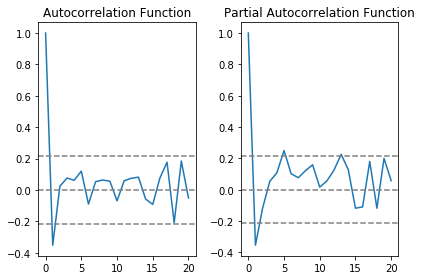

In [6]:
lag_acf = acf(new_ts["Occurence"], nlags=20)
lag_pacf = pacf(new_ts["Occurence"], nlags=20, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(new_ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(new_ts)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

# Obtenir p = premier x tel que la courbe coupe l'interval supérieur de confiance
p=0
while lag_acf[p]>1.96/np.sqrt(len(new_ts)) and p<len(lag_acf):
    p+=1

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(new_ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(new_ts)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

# Obtenir q = premier x tel que la courbe coupe l'interval supérieur de confiance
q=0
while lag_pacf[q]>1.96/np.sqrt(len(new_ts)) and q<len(lag_pacf):
    q+=1

#TODO voir pourquoi ces valeurs 1.96 etc.

# Training

Choosing p=1, q=1 and d=1


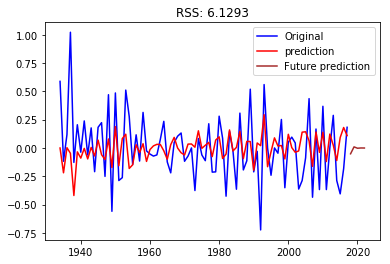

In [7]:
try:
    model = ARIMA(ts_log, order=(p, d, q)) #TODO check if AR and MA models better, even if i don't think so
    results_AR = model.fit(disp=-1) #Seems that it also works without this ? TODO Check
    print ("Choosing p={}, q={} and d={}".format(p,q,d))
except:
    print ("Warning: Chosen p={} and q={} don't work!! Choosing p={}, q={}, d={}".format(p,q,p,q-1,d))
    model = ARIMA(ts_log, order=(p, d, q-1))
    
results_AR = model.fit(disp=-1) #Uses Kalman filter to fit        

#Prédictions futures
forecast_nb=5
forecast_year=[dataM["Year"].iloc[len(dataM["Year"])-1]+i for i in range(1,forecast_nb+1)]
#forecast2,stderr,conf_int = results_AR.forecast(steps=forecast_nb)  ====> semble ne pas marcher !!! TODO Pourquoi ????????
forecast=results_AR.predict(start=len(dataM["Year"]),end=len(dataM["Year"])+forecast_nb-1)

new_ts.dropna(inplace=True)
plt.plot(new_ts["Year"],new_ts["Occurence"],label="Original",color='blue')
plt.plot(dataM["Year"][d:],results_AR.fittedvalues, color='red',label="prediction") #d car nombre de NaN dépend de d.
#plt.plot(forecast_year,forecast2,label="Future prediction",color='green')
plt.plot(forecast_year,forecast,label="Future prediction",color='brown')
plt.legend(loc="best")
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-new_ts["Occurence"])**2))
plt.show()


# Traitement inverse des données

In [8]:
#On peut démontrer la relation par récurrence. Sk = Diffk + 2*S_k-1 - S_k-2
#TODO à vérifier. Ca donne les valeurs très élevées de prédiction à l'échelle d'origine. Faire la fonction avec récursion pour comparer
def originalScaleOrder2(timeseries):
    ts=pd.Series(timeseries, copy=True)
    for k in range(2,len(timeseries)):
        s=0
        for i in range(2,k+1):
            s+=(k-i+1)*timeseries.iloc[i]
        ts.iloc[k]=(s+2*(k-1)*timeseries.iloc[1]-(k-1)*timeseries.iloc[0])
    return ts

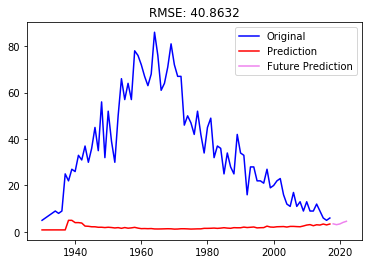

3593912   -0.000639
3594209   -0.219484
3594503    0.002145
3594710   -0.047550
3595009   -0.420007
3595296   -0.034539
3595608   -0.089868
3595922   -0.003828
3596261   -0.097129
3596596    0.004638
3596959   -0.070765
3597276    0.068993
3597607   -0.059899
3597989   -0.102359
3598348    0.079273
3598766   -0.173160
3599115    0.188550
3599505   -0.157254
3599932    0.082741
3600301    0.121175
3600706   -0.181044
3601165   -0.148729
3601620    0.027904
3602126   -0.041559
3602608    0.037262
3603123   -0.118980
3603662   -0.014438
3604222    0.017988
3604758    0.031732
3605295    0.030338
             ...   
3625281    0.293550
3626145   -0.165711
3627087   -0.034313
3627977    0.088978
3628878    0.017246
3629776    0.021376
3630793   -0.097200
3631724    0.120445
3632673    0.003051
3633665   -0.038362
3634766   -0.026355
3635938    0.139400
3637038    0.142796
3637981    0.063027
3639266   -0.162542
3640331    0.140864
3641657   -0.039228
3642617    0.138726
3643905   -0.120117


In [9]:
full_prediction = results_AR.fittedvalues.append(forecast)
full_prediction_year = dataM["Year"].append(pd.Series(forecast_year))

#Fait les opérations inverses pour avoir la prédiction avec trend et seasonality
predictions_ARIMA_diff = pd.Series(full_prediction, copy=True) #pq recreer une autre série ?
if (d==1):
    predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
    predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index) #à changer quand on met la prédiction future ? possible ?
    predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
    predictions_ARIMA = trans_inv(predictions_ARIMA_log)
    #print(predictions_ARIMA)
    
    #Recréer une timeseries de prédiction  pour rendre plus compréhensible
    plt.plot(dataM["Year"],dataM["Occurence"],color="blue",label="Original")
    plt.plot(full_prediction_year[0:len(full_prediction_year)-forecast_nb],predictions_ARIMA[:len(predictions_ARIMA)-forecast_nb],color="Red",label="Prediction")
    plt.plot(full_prediction_year[len(full_prediction_year)-forecast_nb:],predictions_ARIMA[len(predictions_ARIMA)-forecast_nb:],color="Violet",label="Future Prediction")
    plt.legend(loc="best")
    plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA[forecast_nb:]-dataM["Occurence"])**2)/len(dataM["Occurence"])))
    plt.show()
    
elif (d==2):
    predictions_ARIMA_log = originalScaleOrder2(predictions_ARIMA_diff)

    predictions_ARIMA = trans_inv(predictions_ARIMA_log) #np.exp(predictions_ARIMA_log)
    
    
    #XXX Valeurs trop élevées !!!!
    #TODO pourquoi taille décalée de 1 quand d=2 ? Il y a bien 2 valeurs au début qui ne sont pas calculées, mais quand même. Ca devrait être pris en compte
    plt.plot(dataM["Year"],dataM["Occurence"],color="blue",label="Original")
    plt.show()
    plt.plot(full_prediction_year[d:len(full_prediction_year)-forecast_nb],predictions_ARIMA[0:len(predictions_ARIMA)-forecast_nb],color="Red",label="Prediction")
    plt.plot(full_prediction_year[len(full_prediction_year)-forecast_nb:],predictions_ARIMA[len(predictions_ARIMA)-forecast_nb:],color="Violet",label="Future Prediction")
    plt.legend(loc="best")
    plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA[0:len(predictions_ARIMA)-forecast_nb]-dataM["Occurence"])**2)/len(dataM["Occurence"])))
    plt.show()

print(full_prediction)
#print(predictions_ARIMA_log)

# Remarques:

Marche plus ou moins bien suivant les prénoms.

Texas:
- John ok
- Lucas ok
- Bob non
- Jaime non

CA:
- John ok
- Sophie non
- Marie bof: tendance, mais courbes éloignées
- Catherine bof: idem :'(

NY:
- Jon: ordre 2. A améliorer

Même si la confiance est de 99% pour la stationnarité, la prédiction n'est pas géniale parfois.

En utilisant ACF et PACF, la plupart du temps, on devrait choisir p=1, q=1, mais ça bugue. Il faut mettre ARIMA(ts_log, order=(2, 1, 2)). J'ai pu mettre 1 et 1 pour Jaime, mais les résultats étaient mauvais.

====> A revérifier parce qu'il y avait un bug

Quand ça suit plus ou moins la tendance, c'est quand même décalé...

Diff ordre 2 ne marche pas... Parce que pas assez de données ?

prendre en compte les gdes amplitudes, pas prendre forcément log, ms aussi sqrt etc ?
aussi prendre en compte les petites

enlever décalage


## Paramètres à changer éventuellement et autres à faire:
- p et q et d
- time window de 15 années ====> par exemple, valeur trop grande quand c'est un nouveau prénom utilisé que récemment (genre Khaleesi). En même temps, pour ces prénoms, c'est encore plus dur de prédire leur tendance et il y a très peu de chance qu'ils deviennent les prénoms les plus populaires.
=> Et en fait, changer cette valeur ne change pas la conclusion sur la stationnarité ? Donc **peut prendre une valeur plus faible **
- les prénoms et states
- **méthodes pour rendre stationnaire car différentiation ne marche pas toujours!!!!!**

Vérifier pourquoi results_AR.forecast ne marche pas, mais results_AR.predict marche mieux ? Ce n'est pas censé faire la même chose ?

---

# References

https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/  
https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/


https://otexts.org/fpp2/stationarity.html  
https://people.duke.edu/~rnau/411arim2.htm  
https://machinelearningmastery.com/remove-trends-seasonality-difference-transform-python/  
https://machinelearningmastery.com/time-series-data-stationary-python/